  Using cached Cython-3.0.11-cp311-cp311-win_amd64.whl.metadata (3.2 kB)
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
    --------------------------------------- 10.2/614.7 kB ? eta -:--:--
   -- ------------------------------------ 41.0/614.7 kB 487.6 kB/s eta 0:00:02
   ------- -------------------------------- 122.9/614.7 kB 1.0 MB/s eta 0:00:01
   ------------- -------------------------- 215.0/614.7 kB 1.2 MB/s eta 0:00:01
   ------------------ --------------------- 286.7/614.7 kB 1.3 MB/s eta 0:00:01
   ------------------------- -------------- 399.4/614.7 kB 1.5 MB/s eta 0:00:01
   ------------------------------- -------- 491.5/614.7 kB 1.5 MB/s eta 0:00:01
   ------------------------------------ --- 563.2/614.7 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 1.6 MB/s eta 0:00:00
Using cached Cython-3.0.11-cp311-cp311-win_amd64.whl (2.8 MB)
Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed


AttributeError: 'API' object has no attribute 'search'

In [6]:
from google.cloud import bigquery

client = bigquery.Client()
print("Google Cloud BigQuery client initialized successfully.")


DefaultCredentialsError: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.

Enter stock ticker symbol:  NKE


[*********************100%***********************]  1 of 1 completed
C:\Users\91875\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1818.741, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1822.741, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1820.741, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1820.741, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1824.665, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.352 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1006
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 913.333
Date:                Tue, 17 Dec 2024   AIC                          -1824.665
Time:                        05:05:06   BIC                          -1819.753
Sample:                             0   HQIC                         -1822.799
                               - 1006                                  

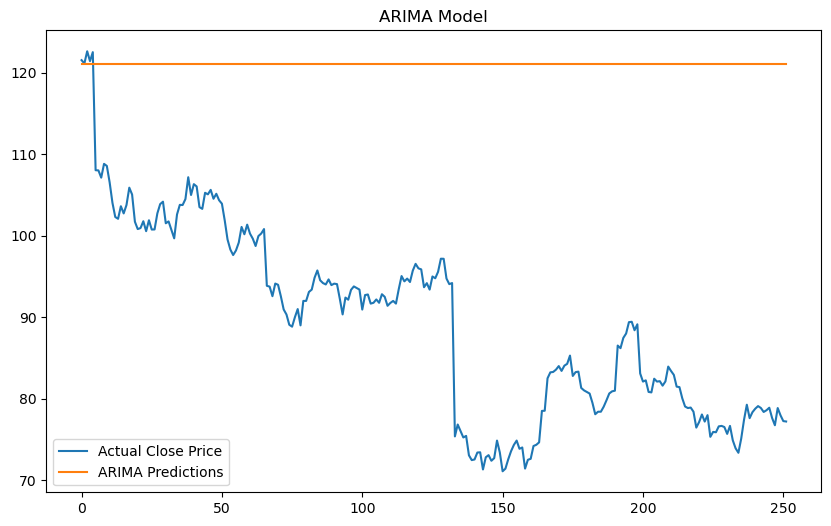

C:\Users\91875\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
LSTM RMSE: 0.09975286726887547, MAE: 0.06813184343500449


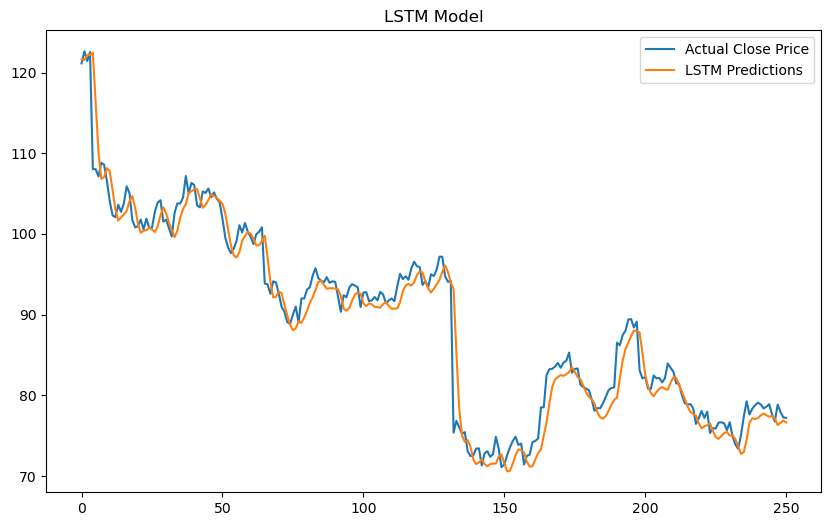

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import logging
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima  # For auto ARIMA
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Function to fetch historical stock data
def fetch_historical_stock_data(ticker):
    """Fetches historical stock data from yfinance."""
    try:
        end = datetime.now()
        start = datetime(end.year - 5, end.month, end.day)  # Get 5 years of data
        data = yf.download(ticker, start=start, end=end)
        if data.empty:
            raise ValueError(f"No data found for ticker: {ticker}")
        return data
    except Exception as e:
        logging.error(f"Error fetching stock data: {e}")
        return None

# Function to create and train ARIMA model
def train_arima_model(train_data):
    """Creates and trains an ARIMA model using auto_arima for parameter selection."""
    try:
        stepwise_fit = auto_arima(train_data, start_p=1, start_q=1,
                                  max_p=5, max_q=5, m=12,  # Adjust ranges if needed
                                  seasonal=False, trace=True,
                                  error_action='ignore',
                                  suppress_warnings=True,
                                  stepwise=True)
        print(stepwise_fit.summary())  # Print model summary
        return stepwise_fit
    except Exception as e:
        logging.error(f"Error training ARIMA model: {e}")
        return None

# Function to evaluate ARIMA model
def evaluate_arima_predictions(model, test_data):
    """Evaluates the ARIMA model on test data."""
    try:
        predictions = model.predict(n_periods=len(test_data))
        rmse = math.sqrt(mean_squared_error(test_data, predictions))
        mae = mean_absolute_error(test_data, predictions)
        return predictions, rmse, mae
    except Exception as e:
        logging.error(f"Error evaluating ARIMA model: {e}")
        return None, None, None

# Function to create and train LSTM model
def train_lstm_model(X_train, y_train):
    """Creates and trains an LSTM model."""
    try:
        model = Sequential()
        model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.3))
        model.add(LSTM(units=64, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(units=64))
        model.add(Dropout(0.3))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)  # Increased epochs
        return model
    except Exception as e:
        logging.error(f"Error training LSTM model: {e}")
        return None

# Function to evaluate LSTM model
def evaluate_lstm_predictions(model, X_test, y_test):
    """Evaluates the LSTM model on test data."""
    try:
        predictions = model.predict(X_test)
        rmse = math.sqrt(mean_squared_error(y_test, predictions))
        mae = mean_absolute_error(y_test, predictions)
        return predictions, rmse, mae
    except Exception as e:
        logging.error(f"Error evaluating LSTM model: {e}")
        return None, None, None

if __name__ == "__main__":
    quote = input("Enter stock ticker symbol: ")
    df = fetch_historical_stock_data(quote)
    if df is None:
        exit()
    df = df.dropna()

    # Use only 'Close' price for modeling
    close_prices = df['Close'].values.reshape(-1, 1) # Reshape for scaling

    scaler = StandardScaler()
    scaled_close = scaler.fit_transform(close_prices)

    train_size = int(len(scaled_close) * 0.8)
    train, test = scaled_close[:train_size], scaled_close[train_size:]

    arima_model = train_arima_model(train)
    if arima_model:
        arima_predictions, arima_rmse, arima_mae = evaluate_arima_predictions(arima_model, test)
        if arima_predictions is not None:
            print(f"ARIMA RMSE: {arima_rmse}, MAE: {arima_mae}")
            plt.figure(figsize=(10, 6))
            plt.plot(close_prices[-len(test):], label='Actual Close Price')  # Use original close prices for plotting
            plt.plot(scaler.inverse_transform(np.array(arima_predictions).reshape(-1, 1)), label='ARIMA Predictions')
            plt.title('ARIMA Model')
            plt.legend()
            plt.show()

    # LSTM Model
    X, y = [], []
    look_back = 7
    for i in range(look_back, len(scaled_close)):
        X.append(scaled_close[i - look_back:i])
        y.append(scaled_close[i])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1)) # Reshape for LSTM input (samples, timesteps, features)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) # Shuffle set to false for time series

    lstm_model = train_lstm_model(X_train, y_train)
    if lstm_model:
        lstm_predictions, lstm_rmse, lstm_mae = evaluate_lstm_predictions(lstm_model, X_test, y_test)
        if lstm_predictions is not None:
            print(f"LSTM RMSE: {lstm_rmse}, MAE: {lstm_mae}")
            plt.figure(figsize=(10, 6))
            plt.plot(close_prices[-len(y_test):], label='Actual Close Price') # Use original close prices for plotting
            plt.plot(scaler.inverse_transform(lstm_predictions.reshape(-1, 1)), label='LSTM Predictions')
            plt.title('LSTM Model')
            plt.legend()
            plt.show()